In [100]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA, FastICA as ICA, NMF
from tqdm import tqdm

from util import decode_npy

In [8]:
# relevant constants
DF = pd.read_csv('../data/main_table.csv')

GAIA_ID_COLNAME = 'source_id'
SDSS_ID_COLNAME = 'specObjId'

C_ORANGE     = '#e69f00'
C_SKYBLUE    = '#56b4e9'
C_GREEN      = '#009e73'
C_VERMILLION = '#d55e00'
C_PURPLE     = '#cc79a7'
C_BLACK      = '#000000'

In [9]:
# plot fontsize settings

SMALL_FONT_SIZE = 22
MEDIUM_FONT_SIZE = 28
LARGE_FONT_SIZE = 28

plt.rc('font', size=SMALL_FONT_SIZE)          # default text sizes
plt.rc('axes', titlesize=LARGE_FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_FONT_SIZE)   # fontsize of the figure title

In [54]:
BINSIZE_X, BINSIZE_Y = 1, 0.002
MIN_WVL, MAX_WVL = 390, 900

bin_centers_x = np.arange(MIN_WVL, MAX_WVL+1, BINSIZE_X)

In [56]:
is_nonvar = DF.nonvar_match_num == 1
is_var    = DF.var_match_num == 1
is_quasar = DF.quasar_match_num == 1

unambiguous_nonvar = is_nonvar & ~is_var & ~is_quasar
unambiguous_var    = ~is_nonvar & is_var & ~is_quasar
unambiguous_quasar = ~is_nonvar & ~is_var & is_quasar

is_unambiguous = unambiguous_nonvar | unambiguous_var | unambiguous_var

DF = DF[is_unambiguous]

In [168]:
data = []

for gaia_id in tqdm(DF[:][GAIA_ID_COLNAME]):
    try:
        sdss_id = DF.loc[DF[GAIA_ID_COLNAME] == gaia_id][SDSS_ID_COLNAME].to_list()[0]
    except:
        print('Could not find an SDSS ID corresponding to the provided Gaia ID')
        continue

    try:
        spectra = decode_npy(f'../data/spectra/spectra_G{gaia_id}_S{sdss_id}.npy')
    except:
        continue

    sampling = spectra['sampling']
    qs = spectra['q']

    mask = (sampling > MIN_WVL) & (sampling < MAX_WVL)

    sampling = sampling[mask]
    qs = qs[mask]

    binned_qs = [ [] for _ in range(len(bin_centers_x)) ]

    floors = np.floor(sampling).astype(np.int64)
    closer_to_higher = (sampling - floors) > 0.5

    indices = floors - MIN_WVL + closer_to_higher

    for i, q in zip(indices, qs):
        binned_qs[i].append(q)

    binned_qs = np.array([ np.mean(ql) for ql in binned_qs ])
    if np.all(~np.isnan(binned_qs)) and np.all(binned_qs > 0):
        data.append(binned_qs)

data = np.array(data)
data.shape

  1%|█                                                                                                                                                                                                                    | 77/15392 [00:00<00:40, 380.66it/s]/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15392/15392 [00:33<00:00, 465.93it/s]


(13406, 511)

In [169]:
N = 5

In [197]:
pca = PCA(n_components=N-1)
pca.fit(data)

mean = pca.mean_
var = pca.explained_variance_ratio_

pca_components = np.vstack((mean, pca.components_))

var

array([0.82112876, 0.12147009, 0.04578318, 0.00353108])

In [199]:
ica = ICA(n_components=N-1, whiten='unit-variance')
ica.fit(data.T)

proj = ica.transform(data.T).T

ica_components = np.vstack((mean, proj))

In [200]:
nmf = NMF(n_components=N, max_iter=1000)
nmf.fit(data)

nmf_components = nmf.components_

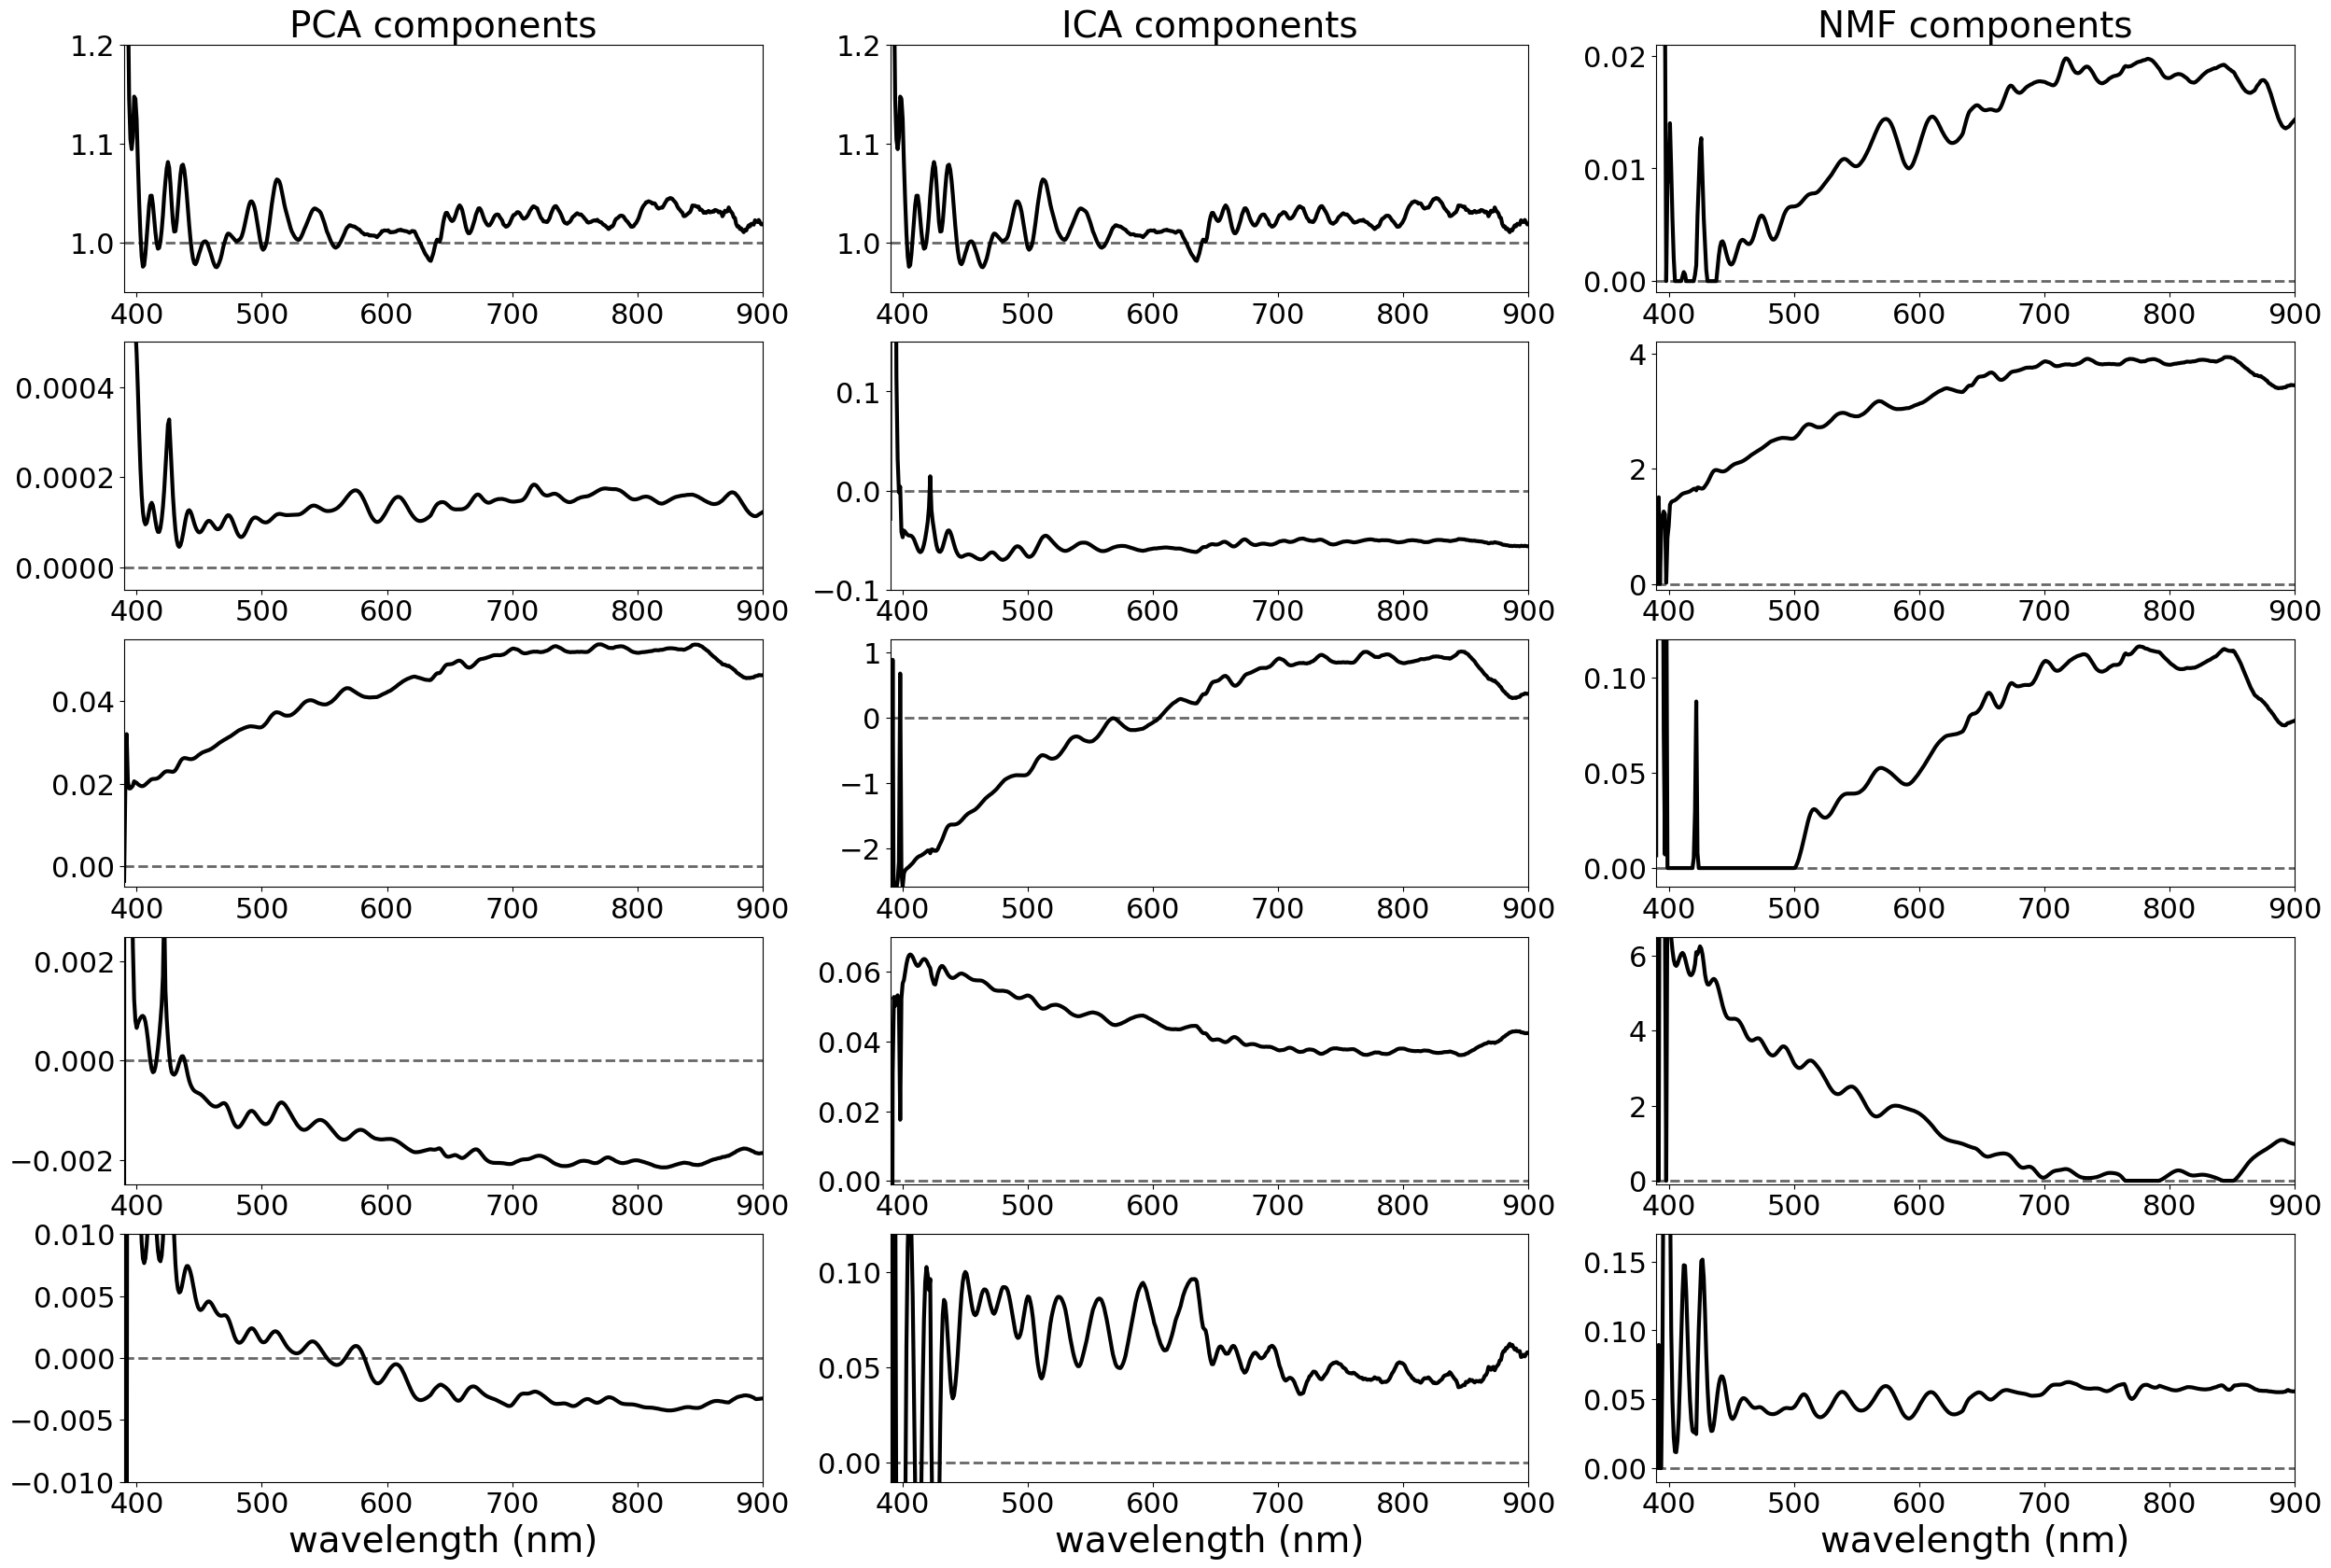

In [226]:
fig, ax = plt.subplots(N, 3, figsize=(30, 20))

ylim = [ [(0.95, 1.2), (-5e-5, 5e-4), (-0.005, 0.055), (-2.5e-3, 2.5e-3), (-1e-2, 1e-2)]
       , [(0.95, 1.2), (-1e-1, 1.5e-1), (-2.6, 1.2), (-1e-3, 7e-2), (-1e-2, 1.2e-1)]
       , [(-1e-3, 2.1e-2), (-0.1, 4.2), (-1e-2, 1.2e-1), (-0.1, 6.5), (-1e-2, 0.17)]
       ]

components = [ pca_components, ica_components, nmf_components ]
titles = [ 'PCA components', 'ICA components', 'NMF components' ]

for j in range(3):
    ax[0][j].set_title(titles[j])
    ax[N-1][j].set_xlabel('wavelength (nm)')
    
    for i in range(N):
        if j < 2:
            m = 1 - int(bool(i))
        else:
            m = 0
            
        ax[i][j].set_xlim(MIN_WVL, MAX_WVL)
        ax[i][j].set_ylim(*ylim[j][i])
        ax[i][j].axhline(m, c='#666666', ls='--', lw=2)
        ax[i][j].plot(bin_centers_x, components[j][i], c='#000000', lw=3)

In [223]:
nmf.reconstruction_err_ / np.sum([ np.dot(row, row) for row in data ])

1.2348633517120786e-05